# CycleGAN

Hello mọi người! Hôm nay mình sẽ viết về một mô hình gây ra nhiều tranh cãi về vấn đề liệu nó có thật sự tốt hay không. Đó là mô hình GAN (Generative Adversarial Network) hay Mạng sinh đối nghịch tạo sinh. Trước tiên cần tìm hiểu mô hình GAN là gì? Đó là mô hình sinh ra dữ liệu mới giống như dữ liệu có sẵn, gồm 2 mạng là Generator (Bộ tạo sinh) và Discriminator (Bộ phân biệt) được sử dụng rộng rãi trong tạo ảnh, tạo video và tạo giọng nói. Hai mạng này sẽ cạnh tranh nhau nhằm nâng cao hiệu suất mô hình, mạng Generator sẽ cố gắng tạo ảnh giống ảnh thật nhất còn mô hình Discriminator cố gắng phân biệt ảnh thật và ảnh giả chính xác nhất. Và hiện nay nhiều người sử dụng nó cho mục đích xấu như giả mạo giọng nói, gương mặt của người nổi tiếng cho các mục đích xấu.

## 0.Introduction

Hôm nay, chúng ta sẽ giải quyết nhiệm vụ GAN: https://www.kaggle.com/competitions/gan-getting-started để tạo sinh các bức ảnh bình thường thành các bức tranh mang phong cách của Monet- một họa sĩ tài ba người Pháp.


Bộ dữ liệu gồm 4 tập: 
* monet_jpg: 300 bức ảnh Monet lưu ở dạng JPEG
* monet_tfrec: 300 bức ảnh Monet ở dạng TFRecord (1 dạng nén tập dữ liệu lớn của TensorFlow)
* photo_jpg : 7028 bức ảnh thường ở dạng JPEG
* photo_tfrec: 7028 bức ảnh thường ở dạng TFRecord
Tất cả các ảnh đã được chuyển về kích thước 256*256

Ở nhiệm vụ này sử dụng đánh giá MiFID (Memorization-informed FID) bằng cách sử dụng FID (Frechet Inception Distance)- đo mức độ khác biệt phân phối Gauss của hình ảnh được sinh ra với sự phân bố của các hình ảnh thực tế dựa vào mô hình Inception từ ảnh Monet (trích lọc thông tin từ ảnh Monet)

Trong nhiệm vụ này mình sử dụng mô hình CycleGAN và DiffAug (Differentiable Augmentation):

![CycleGAN](CycleGan.png)

Mô hình CycleGAN giúp biến đổi từ tập hình ảnh này thành tập hình ảnh khác mà không cần biết đầu ra chính xác cho mỗi bức ảnh như những mô hình supervised learning khác. CycleGAN là một biến thể của mô hình GAN sử dụng 2 bộ tạo sinh Generators và 2 bộ phân biệt Discriminators. Như hình vẽ ở trên, bộ tạo sinh đầu tiên sẽ sinh từ hình ảnh ngựa thường thành ngựa vằn (ảnh mang phong cách Monet trong nhiệm vụ của chúng ta)  G1: A->B, sau đó bộ phân biệt thứ nhất giúp phân biệt ảnh ngựa vằn vừa tạo ra với ảnh ngựa vằn thật. Sau đó, từ ảnh vừa tạo ta lại chuyển về ảnh ngựa thường G2: B->A và bộ phân biệt thứ hai giúp phân biệt ảnh vừa tạo với ngựa thường. Vậy tại sao mô hình này lại hiệu quả hơn? Đó là bởi vì nếu sử dụng mô hình Gan thông thường thì ảnh tạo sẽ sẽ cố gắng giống ảnh B nhất mà làm mất đi các thuộc tính quan trọng của ảnh A, còn mô hình CycleGAN sẽ giúp biến đổi thành hình ảnh B mà không làm mất đi những đặc tính quan trọng của A do có bộ tạo từ B sang A. 

Bởi vì trong bài này có bộ dữ liệu nhỏ ảnh Monet chỉ có 300 bức nên mình sẽ dùng chung bộ Discriminator cho ảnh Monet có 2 đầu ra khác nhau để chúng có thể học được thông số của nhau. Oke, chúng ta haỹ bắt đầu làm thôi nào!

## 1. Load data

Như thường lệ, ta nhập các thư viện cần thiết

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

2024-02-24 07:54:46.107562: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-24 07:54:46.107683: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-24 07:54:46.240964: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Thư viện tensorflow-addons cung cấp các công cụ xử lý hình ảnh cho mô hình Gan

In [2]:
pip install tensorflow-addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 16.7 MB/s eta 0:00:0000:01
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.1.5
    Uninstalling typeguard-4.1.5:
      Successfully uninstalled typeguard-4.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.6.4 requires typeguard<5,>=4.1.2, but you have typeguard 2.13.3 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import tensorflow_addons as tfa

/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Kiểm tra version của tensorflow và sử dụng AUTOTUNE giúp đơn giản hóa quá trình tối ưu, yêu cầu hệ thống tự động điều chỉnh số lượng dữ liệu được tiền xử lý

In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
print(tf.__version__)

2.15.0


Lấy tên các file được lưu trữ dưới dạng TFRecord từ tệp dữ liệu do kaggle cung cấp

In [5]:
MONET_FILENAMES = tf.io.gfile.glob('/kaggle/input/gan-getting-started/monet_tfrec/*.tfrec')
print(len(MONET_FILENAMES))

PHOTO_FILENAMES  = tf.io.gfile.glob('/kaggle/input/gan-getting-started/photo_tfrec/*.tfrec')
print(len(PHOTO_FILENAMES))

5
20


Nhận thấy tập ảnh thường nhiều hơn so với tập tranh Monet

Bây giờ, chúng ta sẽ viết hàm đọc ảnh từ các file ở trên và hàm xử lý hình ảnh để chuyển thành các mảng số giúp cho máy tính dễ dàng tính toán, dùng cho mô hình học sâu

In [6]:
IMAGE_SIZE = [256, 256]      #Mỗi bức ảnh đều có size 256 x 256

def decode_image(image):                             #hàm xử lý ảnh
    image = tf.image.decode_jpeg(image, channels = 3)    #giải mã hình ảnh JPEG thành một tensor
    image = (tf.cast(image, tf.float32)/127.5) - 1       #Chuẩn hóa hình ảnh về giá trị pixel trong khoảng [-1,1]
    image = tf.reshape(image, [*IMAGE_SIZE, 3])          #Chuyển về kích thước chung
    return image

def read_tfrecord(example):                       #hàm đọc ảnh từ file TFRecord
    tfrecord_format = {                           #mô tả cấu trúc trong TFReord
        "image": tf.io.FixedLenFeature([], tf.string),       
    }
    example = tf.io.parse_single_example(example, tfrecord_format)     #dùng để phân tích cú pháp của bản ghi và trả về dữ liệu hình ảnh
    image = decode_image(example['image'])
    return image

Bây giờ ta tạo hàm đọc qua từng file chứa hình ảnh trong TFRecord

In [7]:
def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

Sau khi có các hàm trên, ta áp dụng để lấy ảnh thường và ảnh Monet theo các batch

In [8]:
monet_ds = load_dataset(MONET_FILENAMES).batch(32).prefetch(32)
photo_ds = load_dataset(PHOTO_FILENAMES).batch(32).prefetch(32)

Chúng ta kiểm tra xem ảnh thường có bao nhiêu batch

In [9]:
image_count =0
for _ in photo_ds:
    image_count += 1
print(image_count)

220


7028/32 = 220

Ta thử lấy ví dụ 1 batch để xem dữ liệu

In [10]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

Do plt.imshow yêu cấu hình ảnh chuẩn hóa về khoảng [0, 1] nên ta sẽ tính image*0.5 + 0.5 để chuyển từ [-1, 1] -> [0, 1]

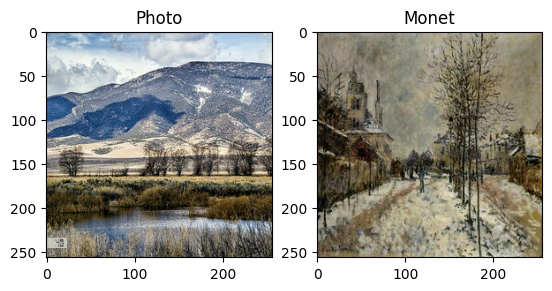

In [11]:
plt.subplot(1,2,1)
plt.title('Photo')
plt.imshow(example_photo[0]*0.5+0.5)      

plt.subplot(1,2,2)
plt.title('Monet')
plt.imshow(example_monet[0]*0.5+0.5)

## 2.Differentiable Augmentation

Một bước quan trọng để năng cao hiệu xuất của mô hình đó là augmentation. Ở nhiệm vụ này không chỉ sử dụng các phương pháp aug cơ bản mà còn sử dụng DiffAugg, bạn có thể tham khảo trong bài báo https://arxiv.org/abs/2006.10738

Đầu tiên ta dùng aug lật ảnh trái phải cơ bản

In [12]:
def data_augment_flip(image):
    image = tf.image.random_flip_left_right(image)
    return image

In [ ]:
def DiffAugment(x, policy = '', channels_first = False):    #hàm duyệt qua các yêu cầu policy để thực hiện tăng cường dữ liệu
    if policy:
        if channels_first:          # kiểm tra xem ảnh có ở dạng (batch size, channels, height, width)
            x = tf.transpose(x, [0,2,3,1])
        for p in policy.split(','):
            for f in AUGMENT_FNS[p]:       #duyệt qua từng loại Aug và áp dụng nó
                x = f(x)
        if channels_first:
            x = tf.transpose(x, [0,3,1,2])
    return x
    
def rand_brightness(x):                  #hàm chỉnh độ sáng 
    magnitude = tf.random.uniform([tf.shape(x)[0], 1,1,1]) - 0.5
    x = x + magnitude
    return x
    
def rand_saturation(x):                    #hàm thay đổi độ bão hòa
    magnitude = tf.random.uniform([tf.shape(x)[0], 1,1,1]) *2
    x_mean = tf.reduce_sum(x, axis = 3, keepdims = True) * 1/3    #tinhs trung bình 3 kênh màu của mỗi pixel
    x = (x - x_mean)* magnitude + x_mean
    return x
    
def rand_contrast(x):                     #hàm thay đổi độ tương phản
    magnitude = tf.random.uniform([tf.shape(x)[0], 1, 1, 1]) + 0.5
    x_mean = tf.reduce_sum(x, axis=[1, 2, 3], keepdims=True) * 5.086e-6      
    x = (x - x_mean) * magnitude + x_mean
    return x

def rand_translation(x, ratio=0.125):       #hàm dịch chuyển ngẫu nhiên ảnh
    batch_size = tf.shape(x)[0]
    image_size = tf.shape(x)[1:3]
    shift = tf.cast(tf.cast(image_size, tf.float32) * ratio + 0.5, tf.int32)    #tính độ dịch chuyển tối đa
    translation_x = tf.random.uniform([batch_size, 1], -shift[0], shift[0] + 1, dtype=tf.int32)
    translation_y = tf.random.uniform([batch_size, 1], -shift[1], shift[1] + 1, dtype=tf.int32)
    grid_x = tf.clip_by_value(tf.expand_dims(tf.range(image_size[0], dtype=tf.int32), 0) + translation_x + 1, 0, image_size[0] + 1)
    grid_y = tf.clip_by_value(tf.expand_dims(tf.range(image_size[1], dtype=tf.int32), 0) + translation_y + 1, 0, image_size[1] + 1)
    x = tf.gather_nd(tf.pad(x, [[0, 0], [1, 1], [0, 0], [0, 0]]), tf.expand_dims(grid_x, -1), batch_dims=1)                 #áp dụng dịch chuyển ngang
    x = tf.transpose(tf.gather_nd(tf.pad(tf.transpose(x, [0, 2, 1, 3]), [[0, 0], [1, 1], [0, 0], [0, 0]]), tf.expand_dims(grid_y, -1), batch_dims=1), [0, 2, 1, 3])    #áp dụng dịch chuyển dọc
    return x


def rand_cutout(x, ratio=0.5):             #hàm loại bỏ bớt 1 phần hình ảnh
    batch_size = tf.shape(x)[0]
    image_size = tf.shape(x)[1:3]
    cutout_size = tf.cast(tf.cast(image_size, tf.float32) * ratio + 0.5, tf.int32)            #tính kích thước phần cần cắt
    offset_x = tf.random.uniform([tf.shape(x)[0], 1, 1], maxval=image_size[0] + (1 - cutout_size[0] % 2), dtype=tf.int32)     #xác định vị trí bắt đầu để cắt trên Ox
    offset_y = tf.random.uniform([tf.shape(x)[0], 1, 1], maxval=image_size[1] + (1 - cutout_size[1] % 2), dtype=tf.int32)
    grid_batch, grid_x, grid_y = tf.meshgrid(tf.range(batch_size, dtype=tf.int32), tf.range(cutout_size[0], dtype=tf.int32), tf.range(cutout_size[1], dtype=tf.int32), indexing='ij')   
    cutout_grid = tf.stack([grid_batch, grid_x + offset_x - cutout_size[0] // 2, grid_y + offset_y - cutout_size[1] // 2], axis=-1)           #tạo lướicắt
    mask_shape = tf.stack([batch_size, image_size[0], image_size[1]])                   
    cutout_grid = tf.maximum(cutout_grid, 0)
    cutout_grid = tf.minimum(cutout_grid, tf.reshape(mask_shape - 1, [1, 1, 1, 3]))
    mask = tf.maximum(1 - tf.scatter_nd(cutout_grid, tf.ones([batch_size, cutout_size[0], cutout_size[1]], dtype=tf.float32), mask_shape), 0)           #tạo mask để cắt, 1- không bị cắt, 0- bị cắt
    x = x * tf.expand_dims(mask, axis=3)
    return x

#từ điển cho các phương pháp tăng cường dữ liệu
AUGMENT_FNS = {
    'color': [rand_brightness, rand_saturation, rand_contrast],
    'translation': [rand_translation],
    'cutout': [rand_cutout],
}
def aug_fn(image):       #hàm aug
    return DiffAugment(image,"color,translation,cutout") 

### Xử lý dữ liệu 

In [13]:
def get_gan_dataset(monet_files, photo_files, augment = None, repeat = True, shuffle = True, batch_size = 1):    #hàm xử lý cả ảnh thường và ảnh Monet để cho vào mô hình
    monet_ds = load_dataset(monet_files)
    photo_ds = load_dataset(photo_files)
    
    if repeat:
        monet_ds = monet_ds.repeat()    #giúp lặp lại dữ liệu nhiều lần 
        photo_ds = photo_ds.repeat()
    if shuffle:
        monet_ds = monet_ds.shuffle(2048)
        photo_ds = photo_ds.shuffle(2048)
        
    monet_ds = monet_ds.batch(batch_size, drop_remainder = True)     #drop_remainder = True sẽ loại bỏ phần batch cuối nếu ko đủ số lượng
    photo_ds = photo_ds.batch(batch_size, drop_remainder = True)
    
    if augment:
        monet_ds = monet_ds.map(augment, num_parallel_calls = AUTOTUNE)
        photo_ds = photo_ds.map(augment, num_parallel_calls = AUTOTUNE)
        
    monet_ds.prefetch(AUTOTUNE)
    photo_ds.prefetch(AUTOTUNE)
    gan_ds = tf.data.Dataset.zip((monet_ds, photo_ds))
    return gan_ds
    

In [14]:
def get_photo_dataset(photo_files, augment = None, repeat = False, shuffle = False, batch_size = 1):         #hàm chỉ lấy mình ảnh thường
    photo_ds = load_dataset(photo_files)
    if repeat:
        photo_ds = photo_ds.repeat()
    if shuffle:
        photo_ds = photo_ds.shuffle(2048)
    photo_ds = photo_ds.batch(batch_size, drop_remainder = True)
    if augment:
        photo_ds = photo_ds.map(augment, num_parallel_calls = AUTOTUNE)
    photo_ds = photo_ds.prefetch(AUTOTUNE)
    return photo_ds

Ta cần lấy final_dataset để cho vào mô hình cần xử lý

In [15]:
final_dataset = get_gan_dataset(MONET_FILENAMES, PHOTO_FILENAMES, augment = data_augment_flip, repeat = True, batch_size = 32)

## 2. FID (Frechet Inception Distance)

In [16]:
inception_model = tf.keras.applications.InceptionV3(input_shape = (256, 256, 3), pooling = "avg", include_top = False)   #dùng mô hình pretrained Iception có sẵn
mix3 = inception_model.get_layer("mixed9").output       #chỉ lấy mô hình đến lớp mixed9
f0 = tf.keras.layers.GlobalAveragePooling2D()(mix3)
    
inception_model = tf.keras.Model(inputs = inception_model.input, outputs = f0)
inception_model.trainable = False

def calculate_activation_statistics_mod(images, fid_model):   #hàm tính các thông số cho phân phối Gauss - tính trung bình và ma trận covariance
    act = tf.cast(fid_model.predict(images), tf.float32)
    mu = tf.reduce_mean(act, axis = 0)
    mean_x = tf.reduce_mean(act, axis=0, keepdims=True)
    mx = tf.matmul(tf.transpose(mean_x), mean_x)
    vx = tf.matmul(tf.transpose(act), act)/tf.cast(tf.shape(act)[0], tf.float32)
    sigma = vx - mx
    return mu, sigma

myFID_mu2, myFID_sigma2 = calculate_activation_statistics_mod(monet_ds,inception_model)        
fids=[] 

10/10 [==============================] - 6s 223ms/step


In [17]:
def calculate_frechet_distance(mu1,sigma1,mu2,sigma2):      #tính khoảng cách Frechet giữa các hình ảnh
    fid_epsilon = 1e-14       
    covmean = tf.linalg.sqrtm(tf.cast(tf.matmul(sigma1,sigma2),tf.complex64))
    covmean = tf.cast(tf.math.real(covmean),tf.float32)  
    tr_covmean = tf.linalg.trace(covmean)
    return tf.matmul(tf.expand_dims(mu1 - mu2, axis=0),tf.expand_dims(mu1 - mu2, axis=1)) + tf.linalg.trace(sigma1) + tf.linalg.trace(sigma2) - 2 * tr_covmean
    
def FID(images,gen_model,inception_model=inception_model,myFID_mu2=myFID_mu2, myFID_sigma2=myFID_sigma2):     #Đánh giá chất lượng hình ảnh bằng FID
    inp = layers.Input(shape=[256, 256, 3], name='input_image')
    x  = gen_model(inp)
    x=inception_model(x)
    fid_model = tf.keras.Model(inputs=inp, outputs=x)                
    mu1, sigma1= calculate_activation_statistics_mod(images,fid_model)
    fid_value = calculate_frechet_distance(mu1, sigma1,myFID_mu2, myFID_sigma2)
    return fid_value

## 3. Generator

Đối với bộ Generators chúng ta sẽ sử dụng mô hình Unet:

![Unet](Unet.png)

In [18]:
output_channels = 3

def downsample(filters, size, apply_instancenorm = True):       #Lớp downsample giảm chiều dài, rộng và tăng chiều sâu  
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean = 0.0, stddev = 0.02)          #khởi tạo chuẩn Gauss
    
    model = keras.Sequential()
    model.add(layers.Conv2D(filters, size, strides = 2, padding = 'same', kernel_initializer = initializer, use_bias = False))     
    if apply_instancenorm:
        model.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))        #lóp chuẩn hóa dữ liệu cho mô hình Gan
    
    model.add(layers.LeakyReLU())
    return model

In [19]:
def upsample(filters, size, apply_dropout = False):              #lớp upsample tăng chiều dài, rộng và giảm chiều sâu
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean = 0.0, stddev = 0.02)
    
    model = keras.Sequential()
    model.add(layers.Conv2DTranspose(filters, size, strides = 2, padding = 'same', kernel_initializer = initializer, use_bias = False))      #lớp chập ngược lại với Conv
    model.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))
    
    if apply_dropout:
        model.add(layers.Dropout(0.5))
    model.add(layers.ReLU())
    return model

Bây giờ ta sẽ xây dựng mô hình cho Bộ tạo sinh

In [20]:
def Generator():
    inputs = layers.Input(shape=[256, 256, 3])
    
    down_stack = [
        downsample(64,4,apply_instancenorm= False),      #(batch_size, 128, 128, 64)
        downsample(128, 4),                              #(batch_size, 64, 64, 128)
        downsample(256, 4),                              #(batch_size, 32, 32, 256)
        downsample(512, 4),                              #(batch_size, 16, 16, 512)
        downsample(512, 4),                              #(batch_size, 8, 8, 512)
        downsample(512, 4),                              #(batch_size, 4, 4, 512)
        downsample(512, 4),                              #(batch_size, 2, 2, 512)
        downsample(512, 4),                              #(batch_size, 1, 1, 512)
    ]
    
    up_stack = [
        upsample(512, 4, apply_dropout = True),          #(batch_size, 2, 2, 512)
        upsample(512, 4, apply_dropout = True),          #(batch_size, 4, 4, 512)
        upsample(512, 4, apply_dropout = True),          #(batch_size, 8, 8, 512)
        upsample(512, 4),                                #(batch_size, 16, 16, 512)
        upsample(256, 4),                                #(batch_size, 32, 32, 256)
        upsample(128, 4),                                #(batch_size, 64, 64, 128)
        upsample(64, 4),                                 #(batch_size, 128, 128, 64)
        
    ]
    
    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(output_channels, 4, strides = 2, padding = 'same', kernel_initializer = initializer, activation = 'tanh')
    
    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
        
    skips = reversed(skips[:-1])
        
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])           #kết hợp các lớp từ bên trái với bên phải của mô hình unet để tránh làm mất dữ liệu skip-connection
    
    x = last(x)
    return keras.Model(inputs = inputs, outputs = x)

## 4. Discriminator

Ta dùng chung 1 mô hình Discriminator cho 2 bộ phân loại, chỉ khác đầu ra(lớp cuối) để phân biệt 2 chức năng khác nhau

In [21]:
def Discrimator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean = 0, stddev = 0.02)
    
    input = layers.Input(shape = [256, 256, 3], name = 'input_image')
    down1 = downsample(64,4,apply_instancenorm = False)(input)
    down2 = downsample(128,4)(down1)
    down3 = downsample(256, 4)(down2)
    
    zero_pad1 = layers.ZeroPadding2D()(down3)
    conv = layers.Conv2D(512, 4, strides = 1, kernel_initializer = initializer, use_bias = False)(zero_pad1)
    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)
    leaky_relu = layers.LeakyReLU()(norm1)
    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)
    #last = layers.Conv2D(1,4, strides = 1, kernel_initializer = initializer)(zero_pad2)
    
    return tf.keras.Model(inputs = input, outputs = zero_pad2)
    

Đầu ra cho mỗi mô hình Discriminator của bộ phân loại ảnh Monet

In [22]:
def DHead():
    initializer = tf.random_normal_initializer(0., 0.02)
    input = layers.Input(shape = [33,33,512], name = 'input_image')
    last = layers.Conv2D(1,4,strides = 1, kernel_initializer = initializer)(input)
    return tf.keras.Model(inputs = input, outputs = last)

Bộ phân loại cho ảnh

In [23]:
def DiscrimatorP():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean = 0, stddev = 0.02)
    
    input = layers.Input(shape = [256, 256, 3], name = 'input_image')
    down1 = downsample(64,4,apply_instancenorm = False)(input)
    down2 = downsample(128,4)(down1)
    down3 = downsample(256, 4)(down2)
    
    zero_pad1 = layers.ZeroPadding2D()(down3)
    conv = layers.Conv2D(512, 4, strides = 1, kernel_initializer = initializer, use_bias = False)(zero_pad1)
    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)
    leaky_relu = layers.LeakyReLU()(norm1)
    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)
    last = layers.Conv2D(1,4, strides = 1, kernel_initializer = initializer)(zero_pad2)
    
    return tf.keras.Model(inputs = input, outputs = last)

## 5. Model

Để bắt đầu tạo model thì ta sẽ khởi tạo các mô hình Generator và Discriminator ở trên

In [24]:
monet_generator = Generator()
photo_generator = Generator()
    
monet_discriminator = Discrimator()
photo_discriminator = DiscrimatorP()
    
dHead1 = DHead()
dHead2 = DHead()

Hãy thử áp dụng với ảnh và xem chuyện gì sẽ xảy ra nhé :))

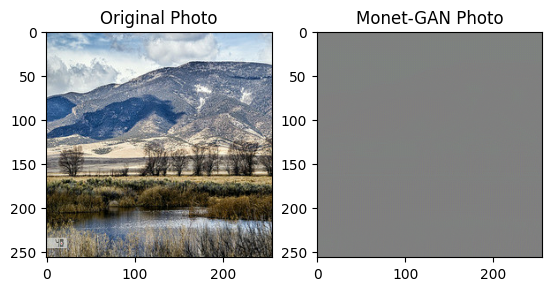

In [25]:
to_monet = monet_generator(example_photo)

plt.subplot(1,2,1)
plt.title("Original Photo")
plt.imshow(example_photo[0]*0.5 + 0.5)

plt.subplot(1,2,2)
plt.title("Monet-GAN Photo")
plt.imshow(to_monet[0]*0.5 +0.5)
plt.show()

Ôi không, chẳng có gì ở bức ảnh Monet-Gan cả! Đừng lo lắng, là do bạn chưa đào tạo mô hình thôi, mô hình vẫn chưa học được bất kì thông số nào cả ))

**CycleGAN**

In [26]:
class CycleGan(keras.Model):
    def __init__(self,monet_generator,photo_generator,monet_discriminator,photo_discriminator,dhead1, dhead2, lambda_cycle = 10, lambda_id = 3,):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator            #Bộ tạo ảnh monet
        self.p_gen = photo_generator            #Bộ tạo ảnh thường
        self.m_disc = monet_discriminator       #Bộ phân loại ảnh monet
        self.p_disc = photo_discriminator       #Bộ phân loại ảnh thường
        self.dhead1 = dhead1                    #head1 - higher score to fake image
        self.dhead2 = dhead2                    #head2 - higher score to real image
        self.lambda_cycle = lambda_cycle        #hệ số lambda cho cycle loss
        self.lambda_id = lambda_id              #hệ số lambda cho identity loss
        
    def compile(self, m_gen_optimizer, p_gen_optimizer, m_disc_optimizer, p_disc_optimizer, gen_loss_fn1, gen_loss_fn2, disc_loss_fn1, disc_loss_fn2, cycle_loss_fn, identity_loss_fn, aug_fn):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer         #khởi tạo các hàm optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn1 = gen_loss_fn1                #Khởi tạo các hàm loss
        self.gen_loss_fn2 = gen_loss_fn2
        self.disc_loss_fn1 = disc_loss_fn1
        self.disc_loss_fn2 = disc_loss_fn2
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        self.aug_fn = aug_fn                             #hàm tăng cường ảnh
        
        self.step_num = 0
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data                 #lấy dữ liệu từ các batch
        batch_size = tf.shape(real_monet)[0]
        with tf.GradientTape(persistent = True) as tape:      #dùng GradientTape để theo dõi các hoạt động giúp cho việc tính toán gradient sau này
            fake_monet = self.m_gen(real_photo, training = True)        #sinh ảnh Monet từ ảnh thường
            cycled_photo = self.p_gen(fake_monet, training = True)      #sinh ảnh thường từ ảnh monet giả ở trên
            
            fake_photo = self.p_gen(real_monet, training = True)        #sinh ảnh thường từ ảnh monet thật
            cycled_monet = self.m_gen(fake_photo, training = True)      #sinh ảnh monet từ ảnh giả trên
            
            same_monet = self.m_gen(real_monet, training=True)          #sinh ảnh monet từ ảnh monet
            same_photo = self.p_gen(real_photo, training =True)         #sinh ảnh thường từ ảnh thường
            
            both_monet = tf.concat([real_monet, fake_monet], axis = 0)  
            aug_monet = self.aug_fn(both_monet)                         #sinh thêm dữ liệu cho ảnh monet thật và giả
            aug_real_monet = aug_monet[:batch_size]
            aug_fake_monet = aug_monet[batch_size:]
            
            disc_fake_monet1 = self.dhead1(self.m_disc(aug_fake_monet, training = True), training = True)           #head1 cho ảnh monet giả
            disc_real_monet1 = self.dhead1(self.m_disc(aug_real_monet, training = True), training = True)           #head1 cho ảnh monet thật
            
            disc_fake_monet2 = self.dhead2(self.m_disc(aug_fake_monet, training = True), training = True)           #head2 cho ảnh monet giả
            disc_real_monet2 = self.dhead2(self.m_disc(aug_real_monet, training = True), training = True)           #head2 cho ảnh monet thật
            
            
            disc_real_photo = self.p_disc(real_photo, training = True)               #phân loại ảnh thường cho ảnh thật
            disc_fake_photo = self.p_disc(fake_photo, training = True)               #phân loại ảnh thường cho anh giả
            
            monet_gen_loss1 = self.gen_loss_fn1(disc_fake_monet1)                      #hàm loss cho 2 đầu
            monet_head_loss1 = self.disc_loss_fn1(disc_real_monet1, disc_fake_monet1)
            monet_gen_loss2 = self.gen_loss_fn2(disc_fake_monet2)
            monet_head_loss2 = self.disc_loss_fn2(disc_real_monet2, disc_fake_monet2)
            
            monet_gen_loss = (monet_gen_loss1 + monet_gen_loss2)*0.4                     #tổng hàm loss cho bộ sinh ảnh monet
            monet_disc_loss = monet_head_loss1 + monet_head_loss2                        #tổng hàm loss cho bộ phân loại ảnh monet
            
            photo_gen_loss = self.gen_loss_fn1(disc_fake_photo)                           #hàm loss cho bộ sinh ảnh thường
            photo_disc_loss = self.disc_loss_fn1(disc_real_photo, disc_fake_photo)        #hàm loss cho bộ phân loại ảnh thường
            
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle/ tf.cast(batch_size, tf.float32))+ self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle/ tf.cast(batch_size, tf.float32))
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_id/ tf.cast(batch_size, tf.float32))
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_id/ tf.cast(batch_size, tf.float32))
    
        monet_generator_gradients = tape.gradient(total_monet_gen_loss, self.m_gen.trainable_variables)          #tính toán gradients
        photo_generator_gradients = tape.gradient(total_photo_gen_loss, self.p_gen.trainable_variables)
        monet_discriminator_gradients = tape.gradient(monet_disc_loss, self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss, self.p_disc.trainable_variables)
        
        monet_head_gradients = tape.gradient(monet_head_loss1, self.dhead1.trainable_variables)
        self.m_disc_optimizer.apply_gradients(zip(monet_head_gradients, self.dhead1.trainable_variables))         #áp dụng gradient tương ứng
        monet_head_gradients = tape.gradient(monet_head_loss2, self.dhead2.trainable_variables)
        self.m_disc_optimizer.apply_gradients(zip(monet_head_gradients, self.dhead2.trainable_variables))
              
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients, self.m_gen.trainable_variables))
        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients, self.p_gen.trainable_variables))
        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients, self.m_disc.trainable_variables))
        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients, self.p_disc.trainable_variables))
        
        return {
            "monet_head_loss1" : monet_head_loss1,
            "monet_head_loss2" : monet_head_loss2,
            "disc_real_monet" : disc_real_monet1,
            "disc_fake_monet" : disc_fake_monet1,
            "disc_real_monet2" : disc_real_monet2,
            "disc_fake_monet2" : disc_fake_monet2,
            "monet_gen_loss" : monet_gen_loss,
            "photo_disc_loss" : photo_disc_loss
        }

**Tạo hàm loss cho các bộ sinh và bộ phân loại**

In [27]:
def discriminator_loss1(real, generated):
    real_loss = tf.math.minimum(tf.zeros_like(real), real-tf.ones_like(real))
    generated_loss = tf.math.minimum(tf.zeros_like(generated), -generated-tf.ones_like(generated))
    total_disc_loss = real_loss + generated_loss
    return tf.reduce_mean(-total_disc_loss * 0.5)     #tối đa hóa mất mát của bộ phân biệt

def discriminator_loss2(real, generated):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits = True, reduction = tf.keras.losses.Reduction.NONE)(tf.zeros_like(real), real)
    generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits = True, reduction = tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)
    total_disc_loss = real_loss+ generated_loss
    return tf.reduce_mean(total_disc_loss*0.5)

In [28]:
def generator_loss1(generated):
    return tf.reduce_mean(-generated)     #tối đa hóa điểm số để bộ phân biệt coi ảnh giả mạo là thật
def generator_loss2(generated):
    return tf.reduce_mean(tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)) #tối đa hóa để bộ phân biệt được hình ảnh giả mạo

In [29]:
def calc_cycle_loss(real_image, cycled_image, LAMBDA):
    loss1 = tf.reduce_sum(tf.abs(real_image - cycled_image))
    return LAMBDA * loss1 * 0.0000152587890625

In [ ]:
def identity_loss(real_image, same_image, LAMBDA):
    loss = tf.reduce_sum(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss *  0.0000152587890625  

Khởi tạo các optimizer cho mô hình, ở đây chúng ta sử dụng Adam

In [32]:
monet_generator_optimizer = tf.keras.optimizers.legacy.Adam(2e-4, beta_1=0.5)
photo_generator_optimizer = tf.keras.optimizers.legacy.Adam(2e-4, beta_1=0.5)

monet_discriminator_optimizer = tf.keras.optimizers.legacy.Adam(2e-4, beta_1=0.5)
photo_discriminator_optimizer = tf.keras.optimizers.legacy.Adam(2e-4, beta_1=0.5)

Và chúng ta hãy khởi tạo mô hình từ các phần ở trên

In [33]:
cycle_gan_model = CycleGan(
    monet_generator, photo_generator, monet_discriminator, photo_discriminator, dHead1, dHead2
)

cycle_gan_model.compile(
    m_gen_optimizer = monet_generator_optimizer,
    p_gen_optimizer = photo_generator_optimizer,
    m_disc_optimizer = monet_discriminator_optimizer,
    p_disc_optimizer = photo_discriminator_optimizer,
    gen_loss_fn1 = generator_loss1,
    gen_loss_fn2 = generator_loss2,
    disc_loss_fn1 = discriminator_loss1,
    disc_loss_fn2 = discriminator_loss2,
    cycle_loss_fn = calc_cycle_loss,
    identity_loss_fn = identity_loss,
    aug_fn = aug_fn,
)

Chạy model với 8 epochs

In [34]:
cycle_gan_model.fit(final_dataset, steps_per_epoch = 1407, epochs = 8)
FID(photo_ds, monet_generator)

Epoch 1/8


2024-02-24 07:56:11.379460: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/sequential_8/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1407/1407 [==============================] - 3339s 2s/step - monet_head_loss1: 0.7699 - monet_head_loss2: 0.6231 - disc_real_monet: 0.3356 - disc_fake_monet: -0.3026 - disc_real_monet2: -0.2695 - disc_fake_monet2: 0.2671 - monet_gen_loss: 0.4783 - photo_disc_loss: 0.6243
Epoch 3/8
1407/1407 [==============================] - 3338s 2s/step - monet_head_loss1: 0.7984 - monet_head_loss2: 0.6354 - disc_real_monet: 0.3172 - disc_fake_monet: -0.2538 - disc_real_monet2: -0.2366 - disc_fake_monet2: 0.2454 - monet_gen_loss: 0.4548 - photo_disc_loss: 0.6934
Epoch 4/8
1407/1407 [==============================] - 3339s 2s/step - monet_head_loss1: 0.8171 - monet_head_loss2: 0.6418 - disc_real_monet: 0.2789 - disc_fake_monet: -0.2225 - disc_real_monet2: -0.1964 - disc_fake_monet2: 0.2028 - monet_gen_loss: 0.4274 - photo_disc_loss: 0.7497
Epoch 5/8
1407/1407 [==============================] - 3339s 2s/step - monet_head_loss1: 0.8182 - monet_head_loss2: 0.6425 - disc_real_monet: 0.2686 - disc_fake_mon

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[10.77516]], dtype=float32)>

## 6.Output

Hãy chạy thử vài ví dụ để xem mô hình có hiệu quả không

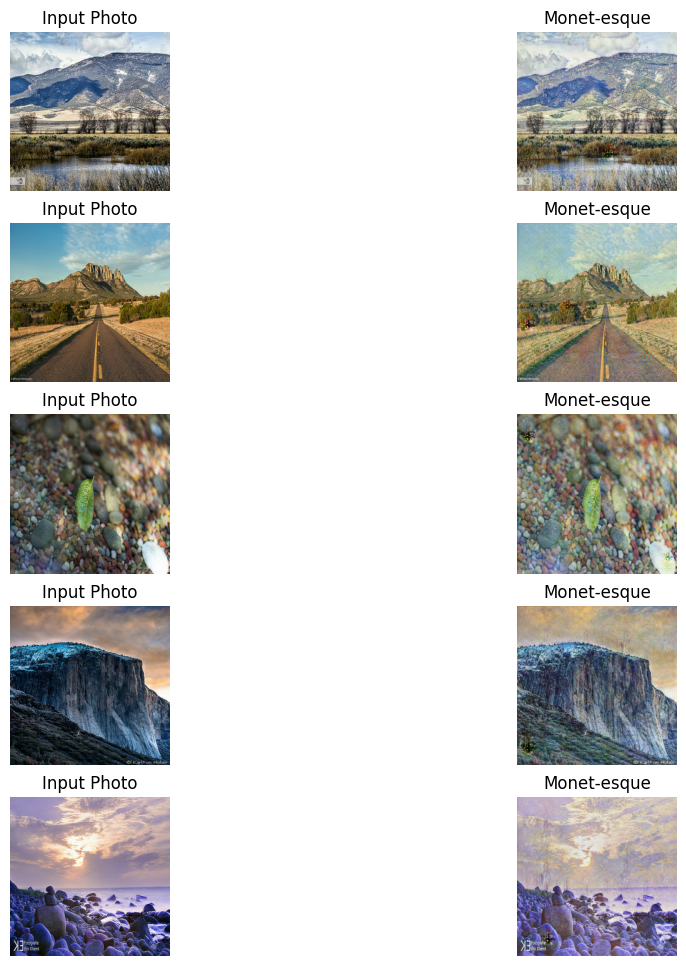

In [35]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

Woa, thật tuyệt vời! Bạn đã tạo ra ảnh Monet thực thụ từ những bức ảnh thường rồi :))

Bây giờ, hãy tạo tất cả ảnh Monet và nộp bài thôi nào

In [36]:
import os
images_dir = "../images"
if not os.path.exists(images_dir):            #kiểm tra và tạo thư mục images
    os.makedirs(images_dir)

In [37]:
import PIL
! mkdir ../images

mkdir: cannot create directory '../images': File exists


Chạy qua từng ảnh trong photo_ds và biến đổi nó thành ảnh Monet

In [38]:
i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

Lưu trữ các ảnh tạo Monet thành tệp zip

In [39]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'

## 7.Conclusion

Vậy là chúng ta đã tìm hiểu mô hình thú vị GAN rồi! Hãy tiếp tục học thêm nhiều điều thú vị nữa nhé!

"Hãy hướng về mặt trời, bóng tối sẽ ngả phía sau bạn" Helen Keller